In [129]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [130]:
# Opening up file containing GWAS data and reading in

file = open("GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

90

In [131]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]
df = pd.DataFrame(columns=columns)

data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [132]:
# Only selecting 100 SNPs located on chromosome 2 

dfAlleles = df.loc[:, "rs11684739":"rs2521953"]
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)
len(df.columns)

106

In [133]:
# Re-encoding SNP of interest

#df.loc[df.PHENOTYPE == 2, ['rs2222162']] = 2
#df.loc[df.PHENOTYPE == 1, ['rs2222162']] = 0

In [134]:
# Removing ID columns and 

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])
dfT = dfTest.T

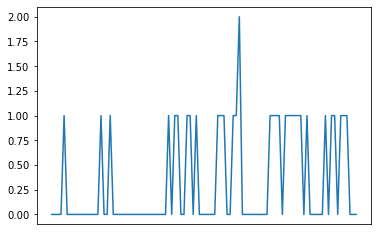

In [135]:
# Visualising entry 1 which is a control 
dfT[0]=dfT[0].astype(float)
dfT[0].plot(xlabel=None) 
plt.gca().axes.get_xaxis().set_visible(False)

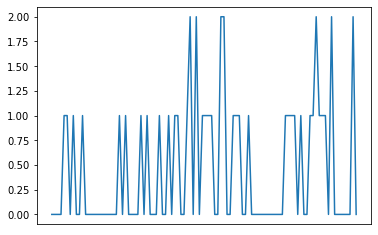

In [136]:
# Visualising entry 2 which is a control 
dfT[1]=dfT[1].astype(float)
dfT[1].plot() 
plt.gca().axes.get_xaxis().set_visible(False)

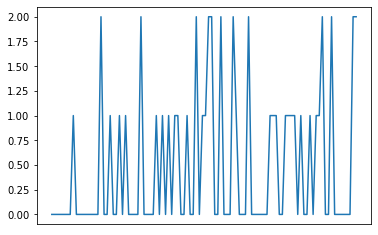

In [137]:
# Visualising entry 3 which is a case

dfT[2]=dfT[2].astype(float)
dfT[2].plot() 
plt.gca().axes.get_xaxis().set_visible(False)

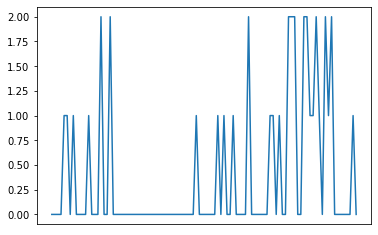

In [138]:
# Visualising entry 87 which is a case

dfT[86]=dfT[86].astype(float)
dfT[86].plot() 
plt.gca().axes.get_xaxis().set_visible(False)

In [139]:
# Replacing missing SNP entries and replacing with most frequent value for that SNP of other entries

imp = SimpleImputer(missing_values="NA", strategy='most_frequent')
idf = pd.DataFrame(imp.fit_transform(dfTest))

In [140]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)

In [141]:
# Classifying GWAS data using decision tree and printing results

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dtc.fit(xTrain, yTrain)
yPredicted = dtc.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = dtc.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))

Training accuracy score: 0.8301886792452831
Testing accuracy score: 0.5833333333333334


In [142]:
# Classifying GWAS data using KNN and printing results

knnClf = KNeighborsClassifier() 
knnClf.fit(xTrain, yTrain)
yPredicted = knnClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = knnClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))

Training accuracy score: 0.7169811320754716
Testing accuracy score: 0.6388888888888888


In [143]:
# Classifying GWAS data using Gaussian Naive Bayes and printing results

gnbClf = GaussianNB() 
gnbClf.fit(xTrain, yTrain)
yPredicted = gnbClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = gnbClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))

Training accuracy score: 0.5660377358490566
Testing accuracy score: 0.4722222222222222


In [144]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [145]:
# Splitting time seriesdata into training data and testing data

xTrain, xTest, yTrain, y_test = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)

In [146]:
# Extracting values from training split

yTrain = yTrain.values
yTest = yTest.values

xTrain = xTrain.reset_index()
xTrain = xTrain.drop(columns=['index'])

xTest = xTest.reset_index()
xTest = xTest.drop(columns=['index'])

In [147]:
# Running rocket kernal transformation on training data

rocket = Rocket()
rocket.fit(xTrain)
xTrainTransform = rocket.transform(xTrain)

In [148]:
# Classifying GWAS Data from rocket transformation using Ridge Classifier

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(xTrainTransform, yTrain)
xTestTransform = rocket.transform(xTest)
yPredict = classifier.predict(xTestTransform)
print("Accuracy with Rocket: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Accuracy with Rocket: 0.556
[[11  4]
 [12  9]]
              precision    recall  f1-score   support

           1       0.48      0.73      0.58        15
           2       0.69      0.43      0.53        21

    accuracy                           0.56        36
   macro avg       0.59      0.58      0.55        36
weighted avg       0.60      0.56      0.55        36



In [149]:
# Classifying GWAS data using MrSEQL

ms = MrSEQLClassifier(seql_mode="clf")
ms.fit(xTrain, yTrain)
yPredict = ms.predict(xTest)
print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

<ipython-input-149-17ba26aa8ba9>:3: FutureWarning: Call to deprecated class MrSEQLClassifier. (MrSEQLClassifier will be removed in v0.10.0. It will be replaced with an implementation based on Numba.) -- Deprecated since version 0.8.1.
  ms = MrSEQLClassifier(seql_mode="clf")
<ipython-input-149-17ba26aa8ba9>:3: FutureWarning: Call to deprecated class SEQLCLF. (SEQLCLF will be removed in v0.10.0) -- Deprecated since version 0.8.1.
  ms = MrSEQLClassifier(seql_mode="clf")


Accuracy with MrSEQL: 0.417
[[15  0]
 [21  0]]
              precision    recall  f1-score   support

           1       0.42      1.00      0.59        15
           2       0.00      0.00      0.00        21

    accuracy                           0.42        36
   macro avg       0.21      0.50      0.29        36
weighted avg       0.17      0.42      0.25        36



C:\Users\Eanna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eanna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Eanna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
